<a href="https://colab.research.google.com/github/comparativechrono/DaphniaTracker/blob/main/DAPHNIA_TRACKER_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install matplotlib opencv-python-headless scikit-image pandas


In [ ]:
from skimage.filters import gaussian


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from IPython.display import display

# Step 1: Load images from a specified directory
def load_images_from_directory(directory):
    image_files = sorted([os.path.join(directory, f) for f in os.listdir(directory)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return image_files

# Define your directory here
directory = "/content"  # <-- Replace with your directory path
image_paths = load_images_from_directory(directory)

# Ensure there are images to process
if not image_paths:
    print("No images found in the directory.")
else:
    print(f"Loaded {len(image_paths)} images.")




Loaded 73 images.


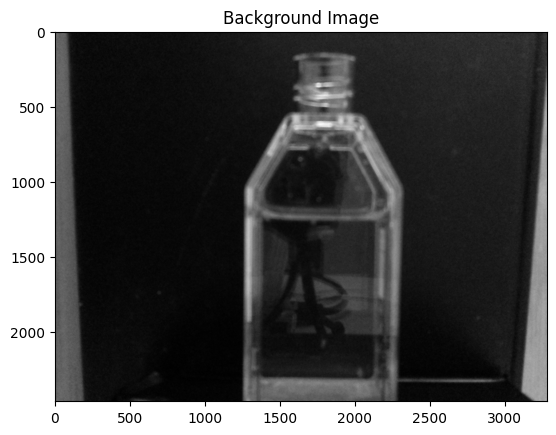

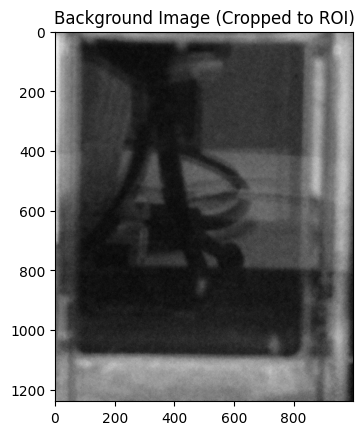

In [ ]:
# Step 2: Load the first image as background
background_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)

# Display the background image
plt.figure()
plt.imshow(background_img, cmap='gray')
plt.title("Background Image")
plt.show()

# Manually define the ROI coordinates (x, y, width, height)
roi_x, roi_y, roi_width, roi_height = 1300, 1225, 1000, 2000  # Define based on your needs

# Crop the background to the ROI
background_roi = background_img[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Display the cropped background ROI
plt.figure()
plt.imshow(background_roi, cmap='gray')
plt.title("Background Image (Cropped to ROI)")
plt.show()

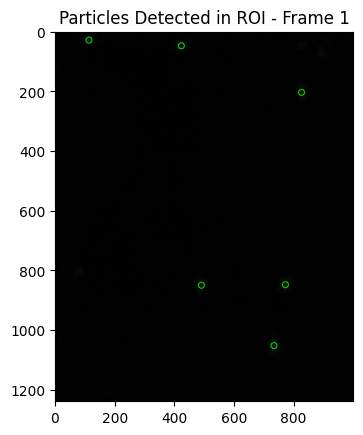

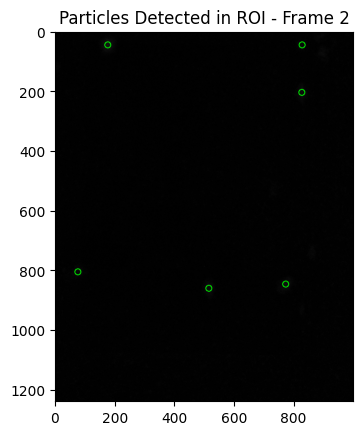

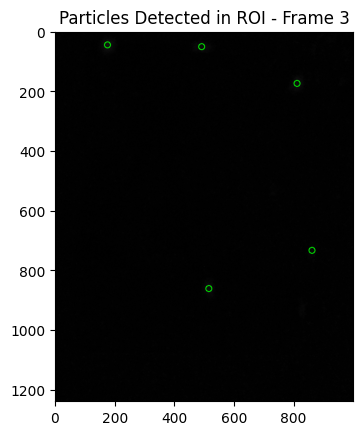

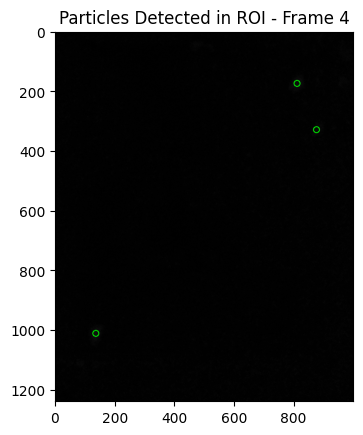

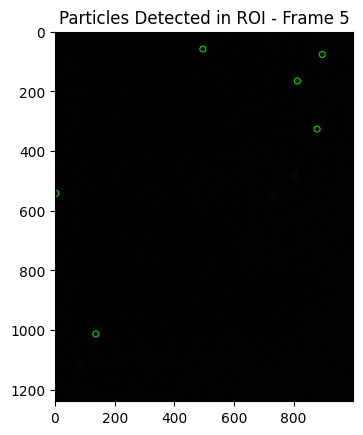

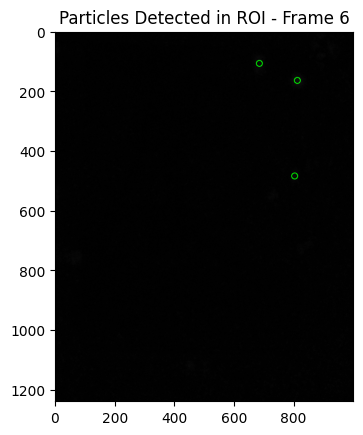

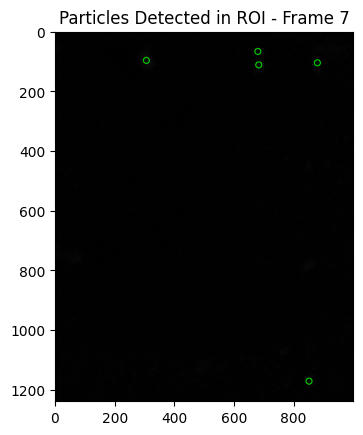

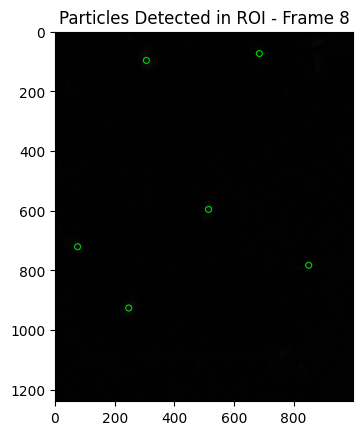

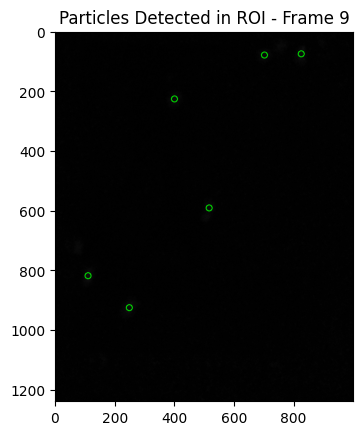

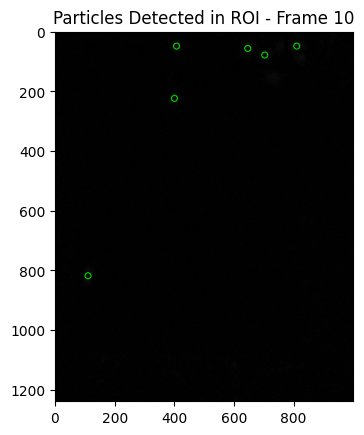

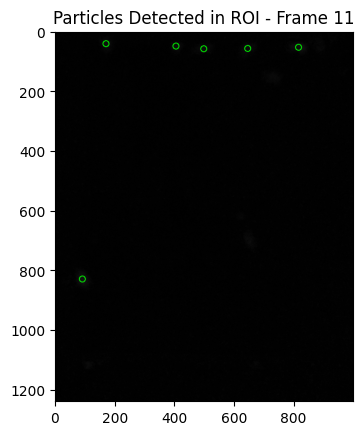

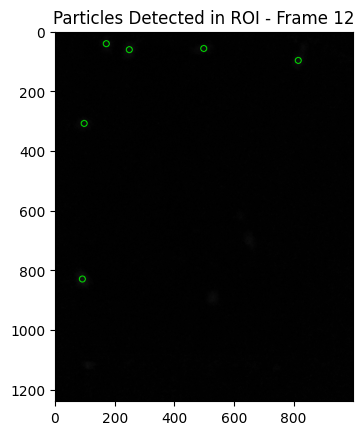

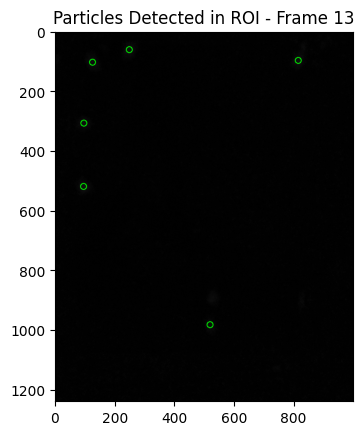

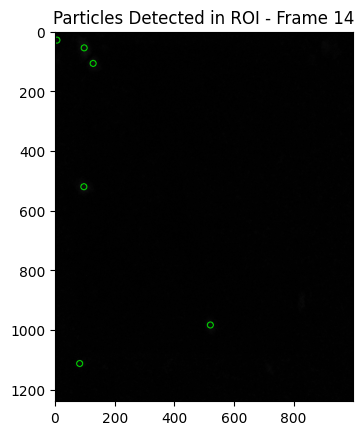

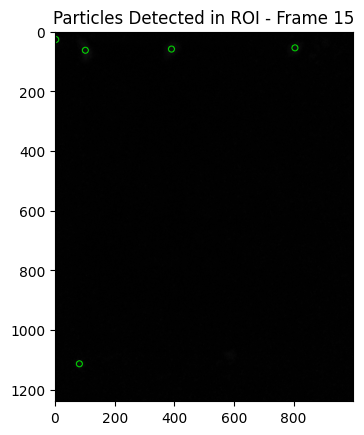

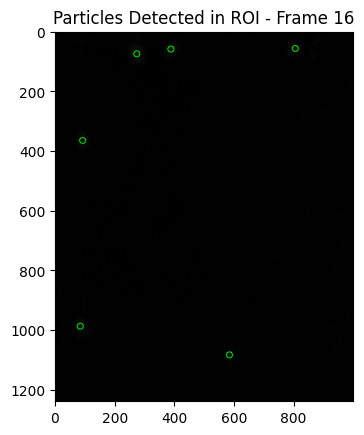

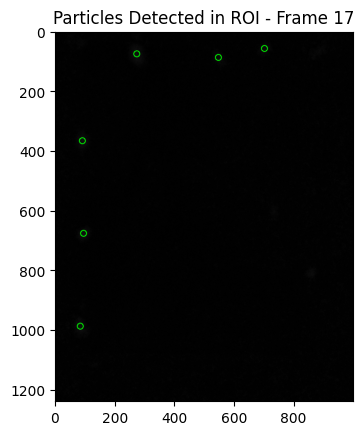

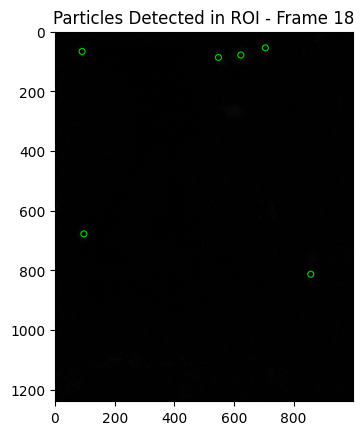

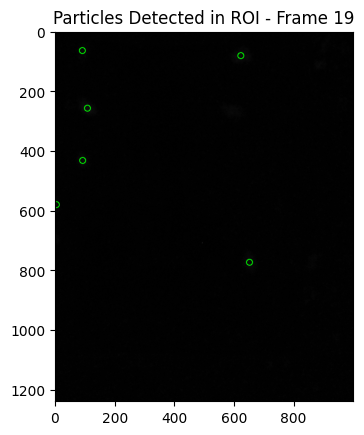

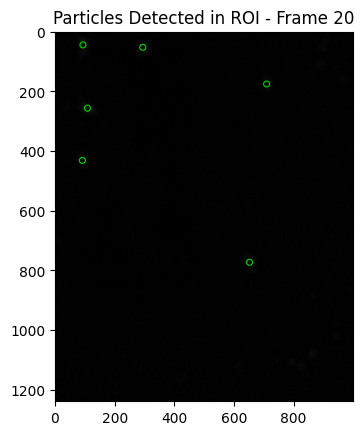

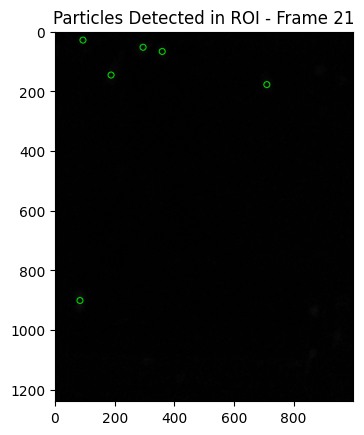

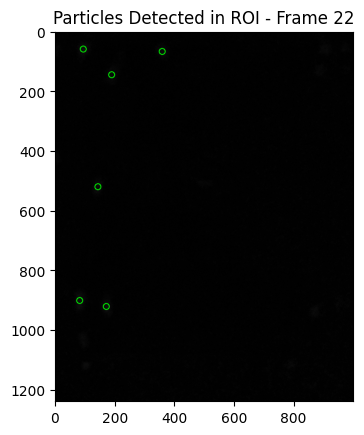

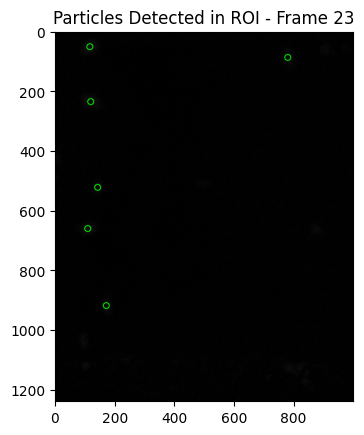

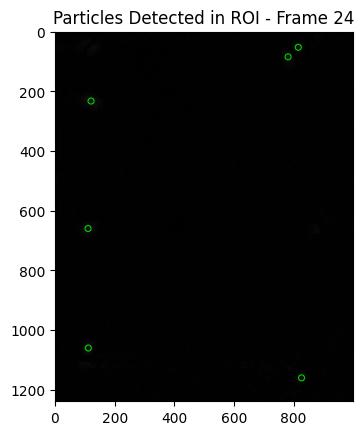

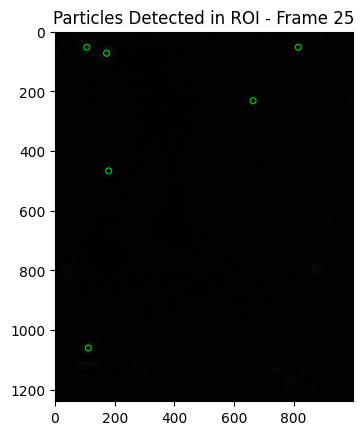

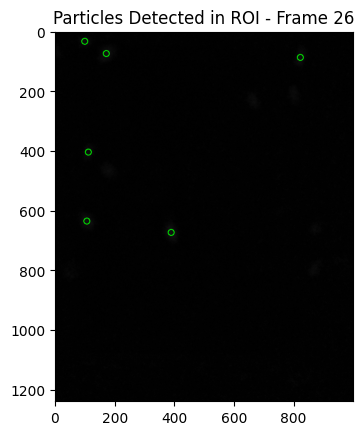

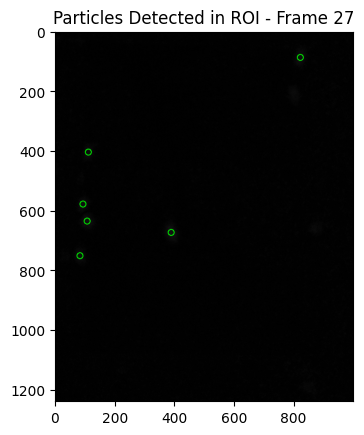

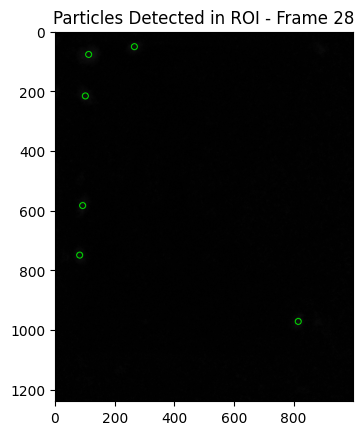

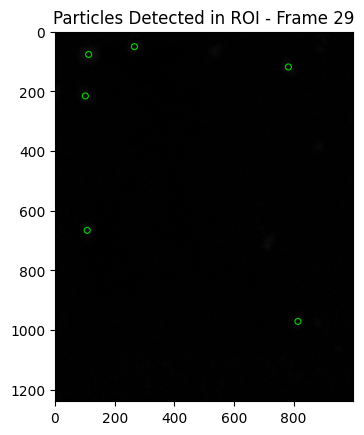

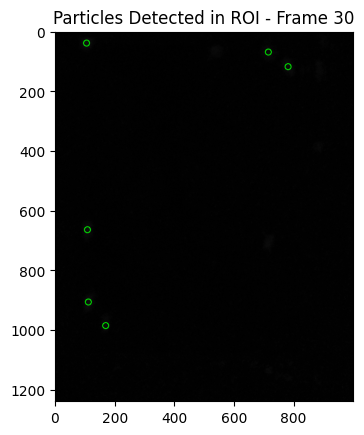

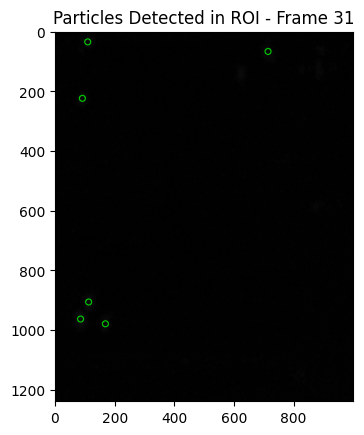

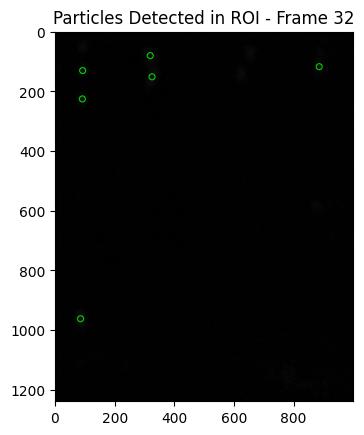

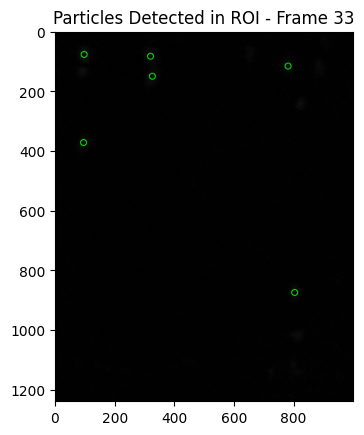

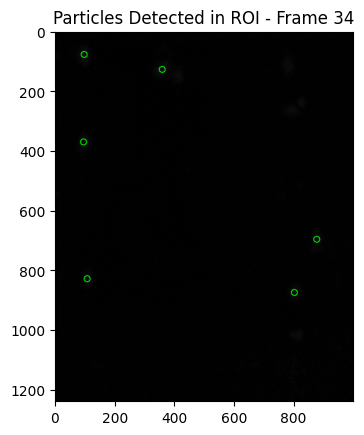

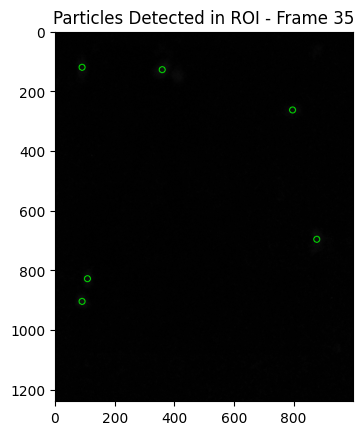

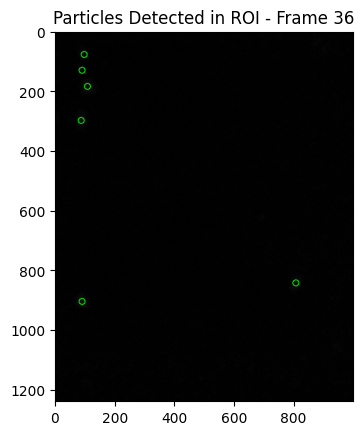

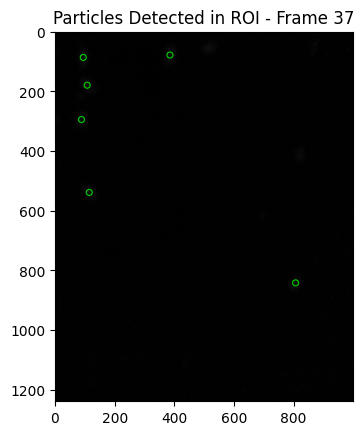

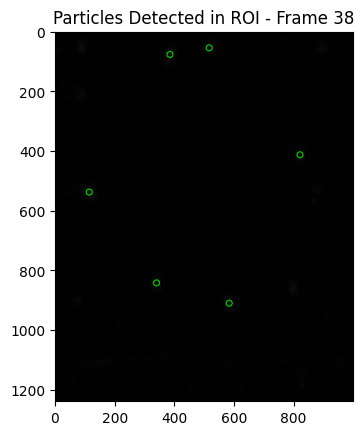

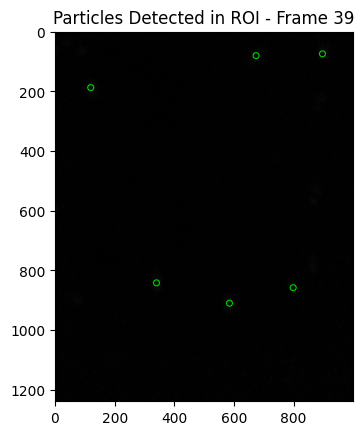

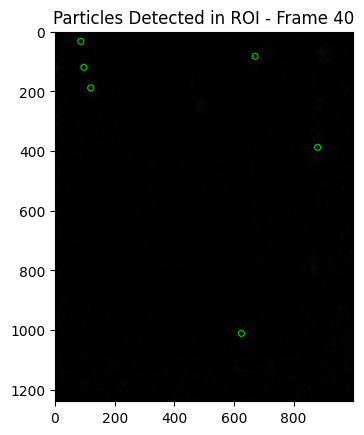

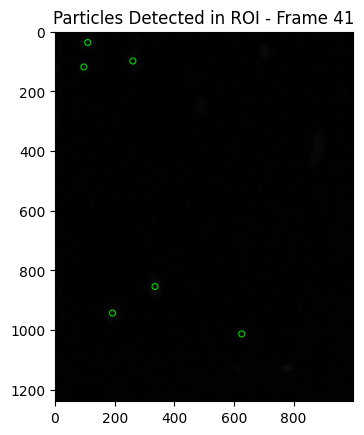

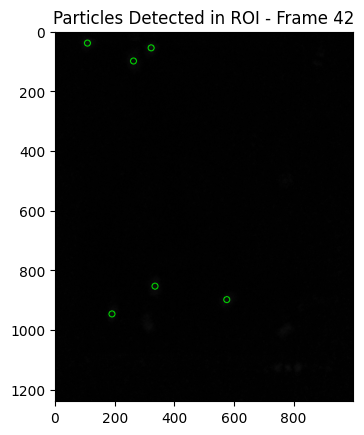

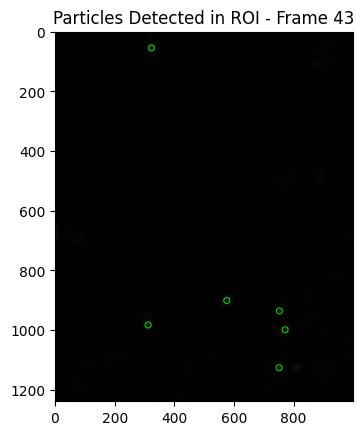

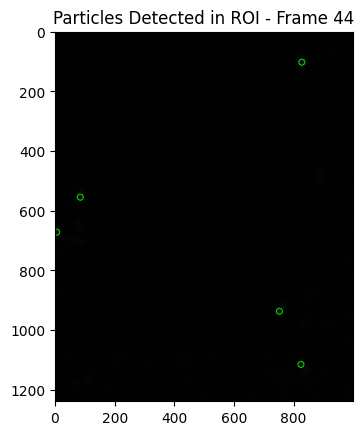

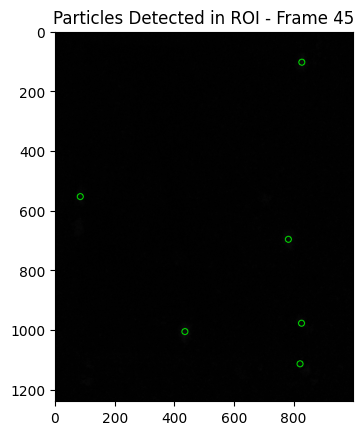

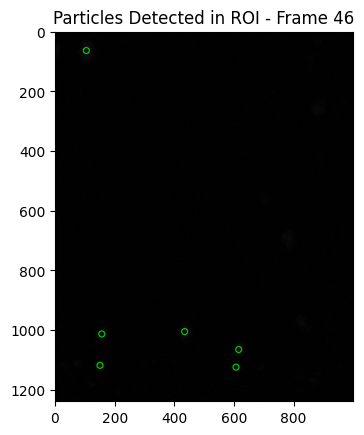

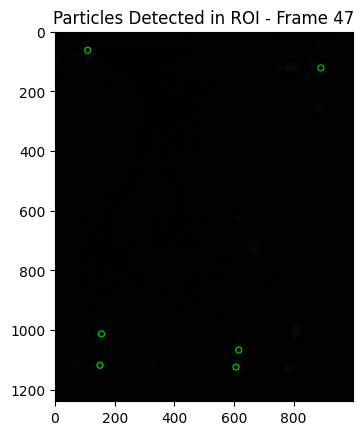

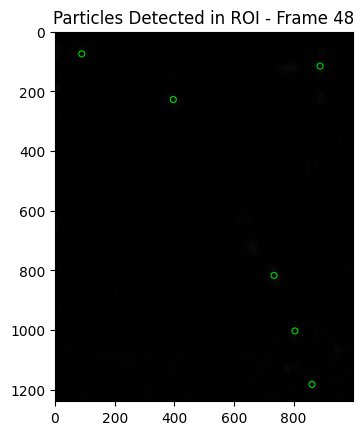

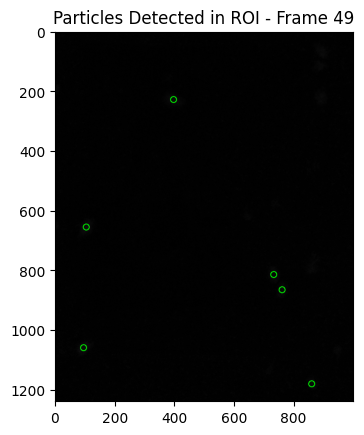

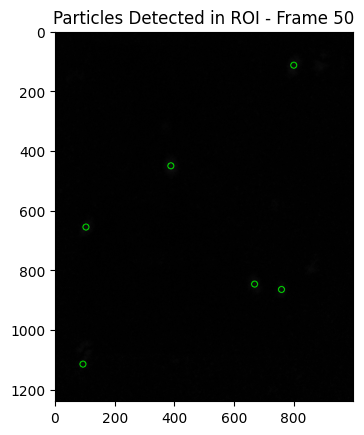

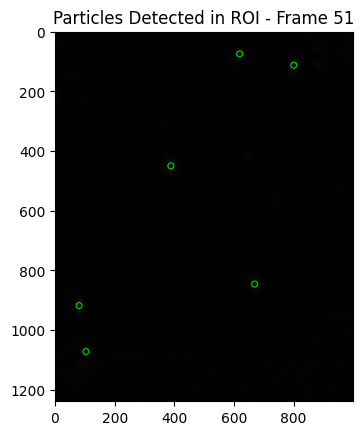

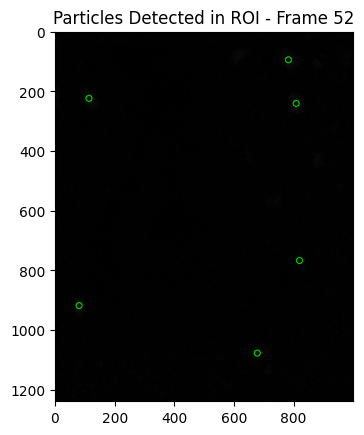

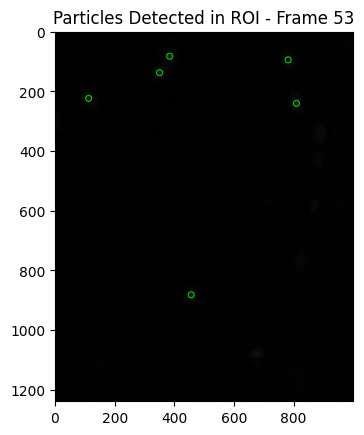

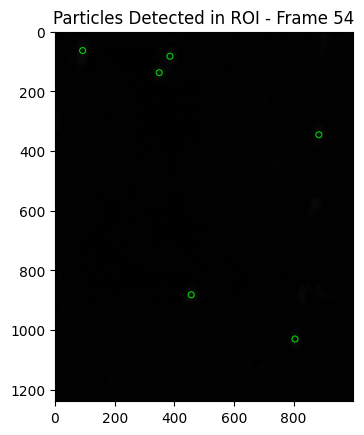

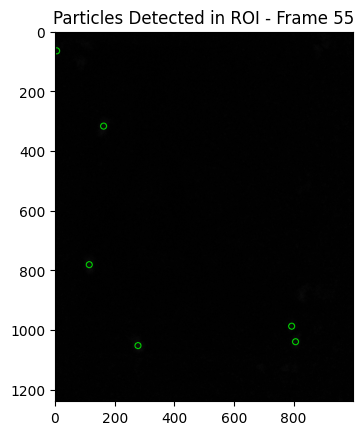

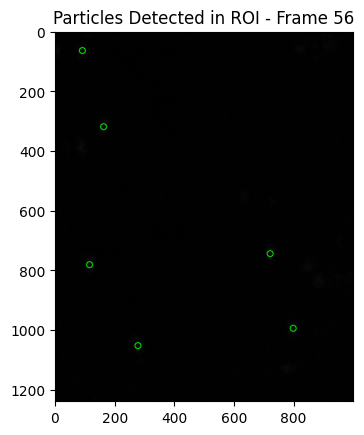

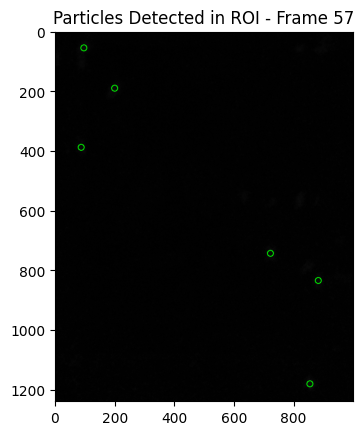

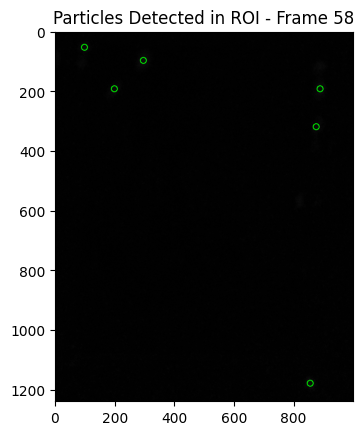

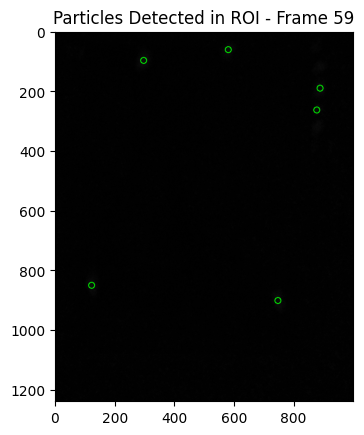

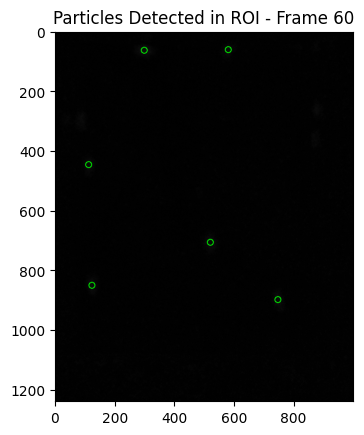

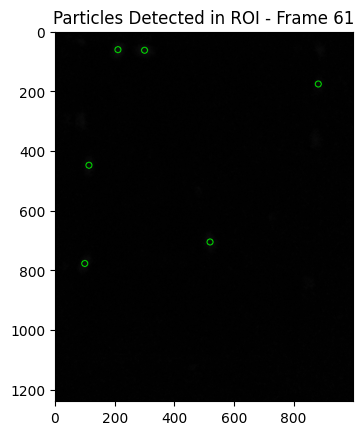

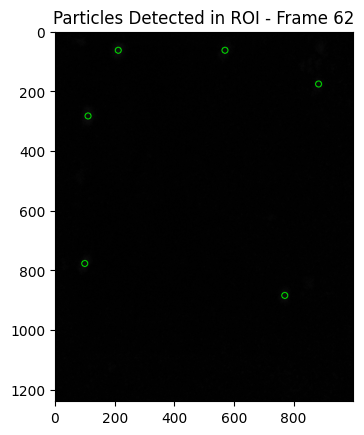

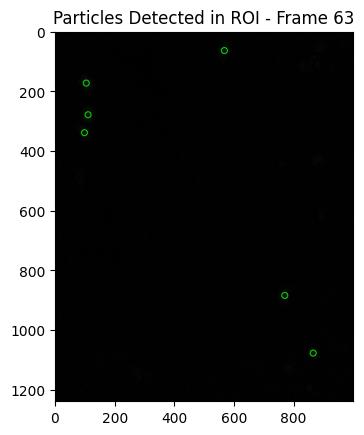

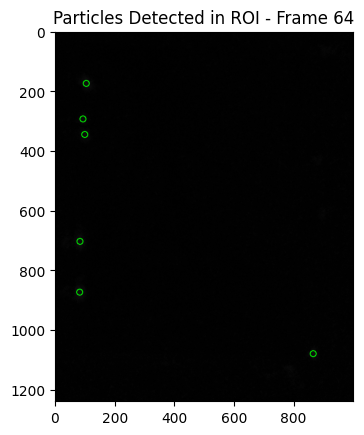

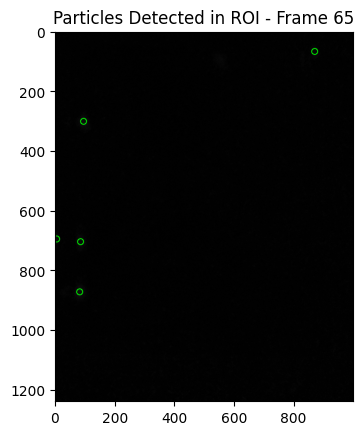

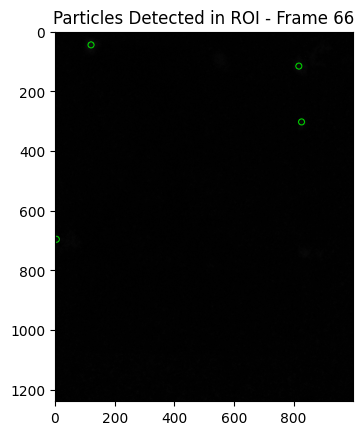

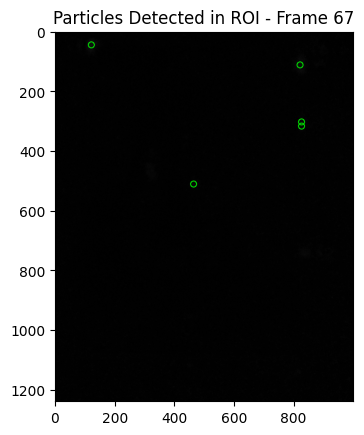

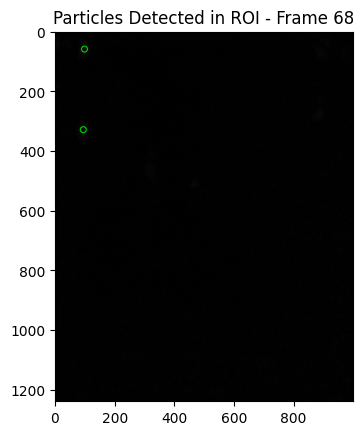

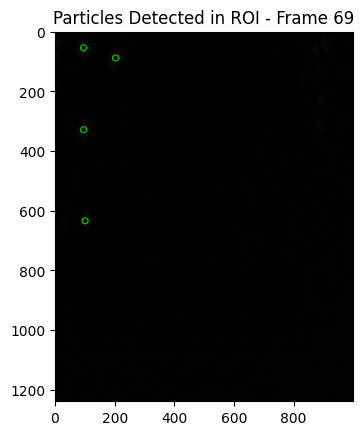

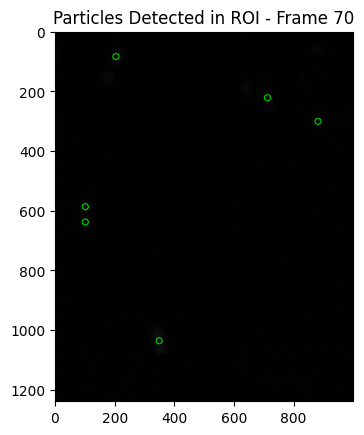

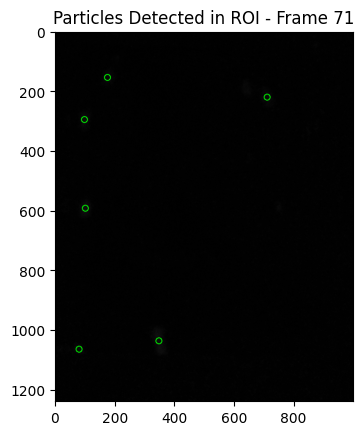

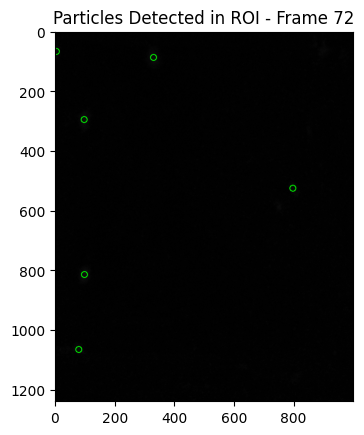

In [ ]:
# Initialize a dictionary to store particle data
particle_data = {}

# Function to detect particles and return their coordinates
def detect_particles(image, min_size=20, max_particles=6):
    binary_image = image > 8  # Adjust threshold if needed
    labeled_img = label(binary_image)
    regions = regionprops(labeled_img)

    # Filter regions by size
    valid_regions = [region for region in regions if region.area >= min_size]

    # Sort regions by area in descending order
    sorted_regions = sorted(valid_regions, key=lambda r: r.area, reverse=True)

    # Select the largest `max_particles` regions
    largest_regions = sorted_regions[:max_particles]

    # Extract particle coordinates (centroid)
    particles = [(int(region.centroid[1]), int(region.centroid[0])) for region in largest_regions]
    return particles


# Step 3: Dynamic background subtraction, ROI cropping, particle detection, and visualization
previous_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)

# Crop the initial background to the ROI
previous_img_roi = previous_img[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]

for idx, path in enumerate(image_paths[1:], start=1):
    # Load the current image
    current_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Crop the current image to the ROI
    current_img_roi = current_img[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]

    # Subtract the previous cropped image from the current cropped image (dynamic background subtraction)
    subtracted_img = cv2.absdiff(previous_img_roi, current_img_roi)

    preprocessed = gaussian(subtracted_img, sigma=2, preserve_range=True)

    # Detect particles in the subtracted ROI image
    particles = detect_particles(preprocessed, min_size=20, max_particles=6)

    # Convert y-coordinates to inverted percentage of the cropped ROI height
    particles_in_percentage = [(x, (1 - y / roi_height) * 100) for (x, y) in particles]

    # Store particle data in the dictionary
    particle_data[f"Frame_{idx}"] = particles_in_percentage

    # Update the background to the current cropped image for the next iteration
    previous_img_roi = current_img_roi

    # Draw detected particles on the subtracted ROI image
    annotated_img = cv2.cvtColor(subtracted_img, cv2.COLOR_GRAY2BGR)
    for (x, y_percent) in particles_in_percentage:
        # Convert percentage back to pixel for visualization (inverted)
        y_pixel = int((1 - y_percent / 100) * roi_height)
        cv2.circle(annotated_img, (x, y_pixel), radius=10, color=(0, 255, 0), thickness=2)

    # Display the annotated image
    plt.figure()
    plt.imshow(annotated_img)
    plt.title(f"Particles Detected in ROI - Frame {idx}")
    plt.show()

# Step 4: Convert particle data to a DataFrame
particle_df = pd.DataFrame.from_dict(particle_data, orient='index')



In [ ]:
display(particle_df)


0                          1  \
Frame_1                (732, 47.35)  (770, 57.550000000000004)   
Frame_2                 (176, 97.7)   (771, 57.60000000000001)   
Frame_3                (175, 97.65)               (809, 91.25)   
Frame_4                 (809, 91.2)   (136, 49.35000000000001)   
Frame_5    (810, 91.64999999999999)   (136, 49.25000000000001)   
...                             ...                        ...   
Frame_68                (94, 83.45)                 (98, 97.0)   
Frame_69                 (95, 97.2)                (202, 95.5)   
Frame_70                (348, 48.1)                (101, 70.6)   
Frame_71  (347, 48.150000000000006)   (101, 70.30000000000001)   
Frame_72    (98, 59.20000000000001)                 (97, 85.2)   

                                 2                         3             4  \
Frame_1               (824, 89.75)              (489, 57.45)  (422, 97.55)   
Frame_2               (514, 56.95)              (825, 89.75)  (826, 97.65)   
Frame_3   (490, 97.39999999999999)  (514, 56.89999999999999)   (859, 63.3)   
Frame_4                (874, 83.5)                      None          None   
Frame_5                (494, 97.0)              (876, 83.55)    (2, 72.85)   
...                            ...                       ...           ...   
Frame_68                      None                      None          None   
Frame_69                (95, 83.5)              (100, 68.25)          None   
Frame_70               (101, 68.0)               (203, 95.7)   (710, 88.8)   
Frame_71                (98, 85.2)               (709, 88.9)   (80, 46.75)   
Frame_72              (329, 95.55)  (79, 46.699999999999996)     (4, 96.6)   

                                 5  
Frame_1                (113, 98.5)  
Frame_2   (76, 59.699999999999996)  
Frame_3                       None  
Frame_4                       None  
Frame_5               (893, 96.05)  
...                            ...  
Frame_68                      None  
Frame_69                      None  
Frame_70  (879, 84.89999999999999)  
Frame_71              (175, 92.25)  
Frame_72               (795, 73.7)  

[72 rows x 6 columns]

In [ ]:
# Calculate the mean, standard deviation, and SEM of y-coordinates for the filtered particles
filtered_y_coords = particle_df.applymap(lambda coord: coord[1] if coord is not None else np.nan)
mean_y = filtered_y_coords.mean(axis=1)
std_y = filtered_y_coords.std(axis=1)
sem_y = std_y / np.sqrt(filtered_y_coords.notna().sum(axis=1))

# Create a DataFrame to combine these variables
results_df = pd.DataFrame({
    'Mean_Y': mean_y,
    'Std_Y': std_y,
    'SEM_Y': sem_y
})


<ipython-input-78-d2a1b6ab1b89>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_y_coords = particle_df.applymap(lambda coord: coord[1] if coord is not None else np.nan)


In [ ]:
display(results_df)

Mean_Y      Std_Y      SEM_Y
Frame_1   74.691667  23.042448   9.407040
Frame_2   76.558333  20.464394   8.354554
Frame_3   81.300000  19.652576   8.788899
Frame_4   74.683333  22.274556  12.860221
Frame_5   81.725000  18.296222   7.469401
...             ...        ...        ...
Frame_68  90.225000   9.581297   6.775000
Frame_69  86.112500  13.378489   6.689244
Frame_70  76.016667  17.336138   7.077449
Frame_71  71.925000  20.391929   8.324970
Frame_72  76.158333  20.184509   8.240291

[72 rows x 3 columns]

In [ ]:
#Adjust to start time
adjust_time = 2.5

In [ ]:
# Reset the index to sequential numbers
results_df.reset_index(drop=True, inplace=True)

# Add time columns based on the new index
results_df['Time_Minutes'] = results_df.index * 20
results_df['Time_Hours'] = results_df['Time_Minutes'] / 60 + adjust_time



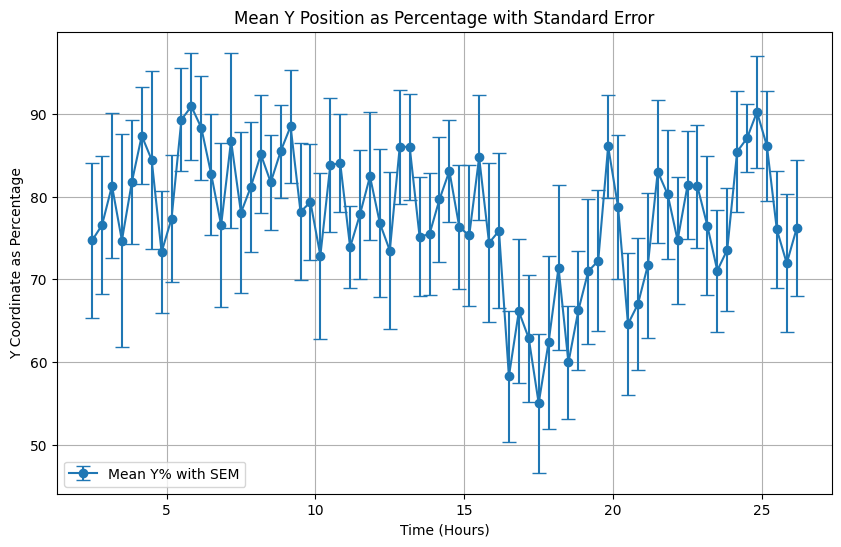

In [ ]:
import matplotlib.pyplot as plt

# Plot mean Y with SEM using time as x-axis
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['Time_Hours'], results_df['Mean_Y'],
             yerr=results_df['SEM_Y'], fmt='o-', capsize=5, label='Mean Y% with SEM')

plt.xlabel('Time (Hours)')
plt.ylabel('Y Coordinate as Percentage')
plt.title('Mean Y Position as Percentage with Standard Error')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Display the final DataFrame with Time, Mean, Std Dev, and SEM
from IPython.display import display

print("Summary of Y-Coordinates with Time, Mean, Std Dev, and SEM:")
display(results_df[['Time_Minutes', 'Time_Hours', 'Mean_Y', 'Std_Y', 'SEM_Y']])


Summary of Y-Coordinates with Time, Mean, Std Dev, and SEM:


Time_Minutes  Time_Hours     Mean_Y      Std_Y      SEM_Y
0              0    2.500000  74.691667  23.042448   9.407040
1             20    2.833333  76.558333  20.464394   8.354554
2             40    3.166667  81.300000  19.652576   8.788899
3             60    3.500000  74.683333  22.274556  12.860221
4             80    3.833333  81.725000  18.296222   7.469401
..           ...         ...        ...        ...        ...
67          1340   24.833333  90.225000   9.581297   6.775000
68          1360   25.166667  86.112500  13.378489   6.689244
69          1380   25.500000  76.016667  17.336138   7.077449
70          1400   25.833333  71.925000  20.391929   8.324970
71          1420   26.166667  76.158333  20.184509   8.240291

[72 rows x 5 columns]

In [ ]:
# Calculate the 3-frame sliding average for Mean_Y
results_df['Mean_Y_Sliding_Avg'] = results_df['Mean_Y'].rolling(window=9, min_periods=1).mean()


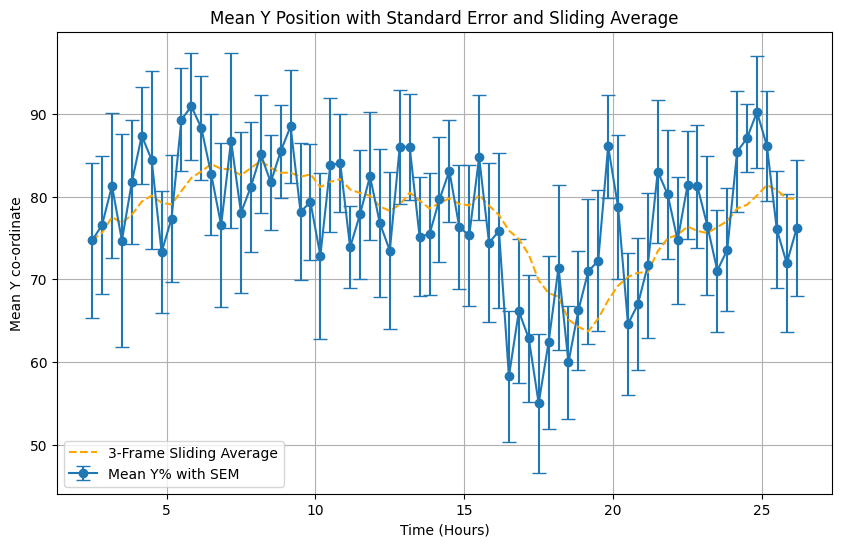

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the original Mean Y with SEM
plt.errorbar(results_df['Time_Hours'], results_df['Mean_Y'],
             yerr=results_df['SEM_Y'], fmt='o-', capsize=5, label='Mean Y% with SEM')

# Plot the 3-frame sliding average
plt.plot(results_df['Time_Hours'], results_df['Mean_Y_Sliding_Avg'],
         linestyle='--', color='orange', label='3-Frame Sliding Average')

plt.xlabel('Time (Hours)')
plt.ylabel('Mean Y co-ordinate')
plt.title('Mean Y Position with Standard Error and Sliding Average')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from IPython.display import display

print("Summary of Y-Coordinates with Time, Mean, Std Dev, SEM, and Sliding Average:")
display(results_df[['Time_Minutes', 'Time_Hours', 'Mean_Y', 'Std_Y', 'SEM_Y', 'Mean_Y_Sliding_Avg']])


Summary of Y-Coordinates with Time, Mean, Std Dev, SEM, and Sliding Average:


Time_Minutes  Time_Hours     Mean_Y      Std_Y      SEM_Y  \
0              0    2.500000  74.691667  23.042448   9.407040   
1             20    2.833333  76.558333  20.464394   8.354554   
2             40    3.166667  81.300000  19.652576   8.788899   
3             60    3.500000  74.683333  22.274556  12.860221   
4             80    3.833333  81.725000  18.296222   7.469401   
..           ...         ...        ...        ...        ...   
67          1340   24.833333  90.225000   9.581297   6.775000   
68          1360   25.166667  86.112500  13.378489   6.689244   
69          1380   25.500000  76.016667  17.336138   7.077449   
70          1400   25.833333  71.925000  20.391929   8.324970   
71          1420   26.166667  76.158333  20.184509   8.240291   

    Mean_Y_Sliding_Avg  
0            74.691667  
1            75.625000  
2            77.516667  
3            76.808333  
4            77.791667  
..                 ...  
67           80.114815  
68           81.381019  
69           80.790278  
70           79.757870  
71           79.723611  

[72 rows x 6 columns]

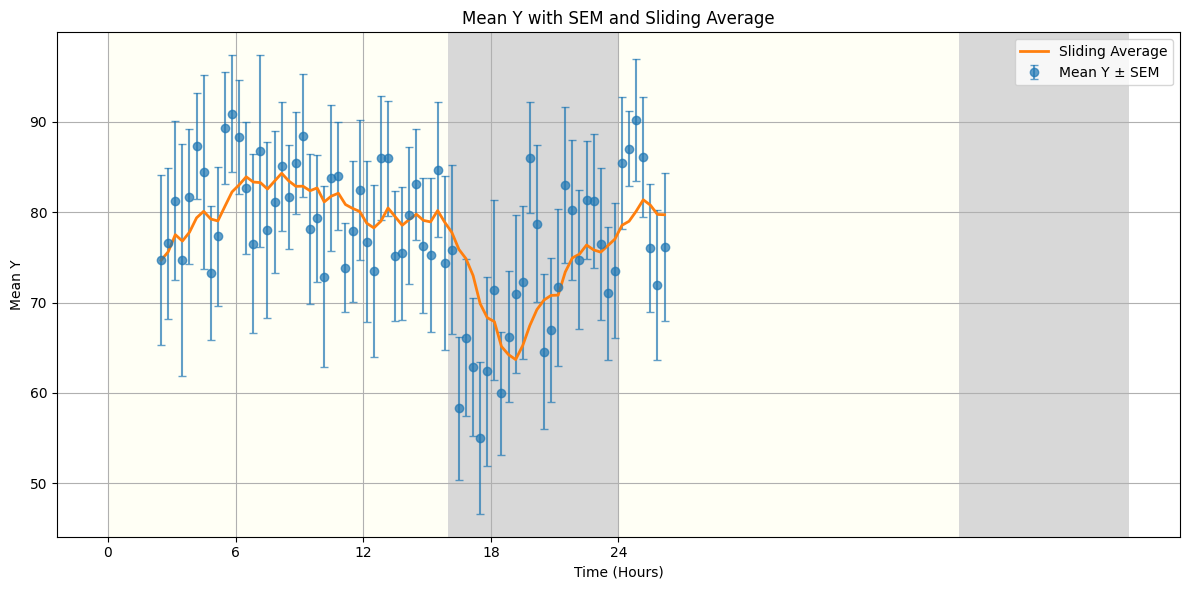

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.errorbar(results_df['Time_Hours'], results_df['Mean_Y'], yerr=results_df['SEM_Y'], fmt='o', label='Mean Y ± SEM', capsize=3, alpha=0.7)
plt.plot(results_df['Time_Hours'], results_df['Mean_Y_Sliding_Avg'], label='Sliding Average', linewidth=2)

# Add light and dark cycle bars
max_time = results_df['Time_Hours'].max()
cycle_length = 24

for i in range(0, int(np.ceil(max_time / cycle_length))):
    start_day = i * cycle_length
    plt.axvspan(start_day, start_day + 16, facecolor='lightyellow', alpha=0.3)  # Day (0-12 hours)
    plt.axvspan(start_day + 16, start_day + 24, facecolor='gray', alpha=0.3)    # Night (12-24 hours)


# Labels and Title
plt.xlabel('Time (Hours)')
plt.ylabel('Mean Y')
plt.title('Mean Y with SEM and Sliding Average')
plt.xticks(np.arange(0, max_time, 6))  # X-axis major ticks at every 6 hours
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()